# Performance comparison

This notebook can be used to compare the performance of GPy and GPyTorch. The GPyTorch code will be tested on the GPU as well.

## Imports

In [1]:
from scipy.io import wavfile as wav
import gpytorch
import torch
import GPy
import math
import numpy

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

Preparation of the sound file that will be used in the comparison. This includes making guesses for the hyperparameters that will be used in the GP models later.

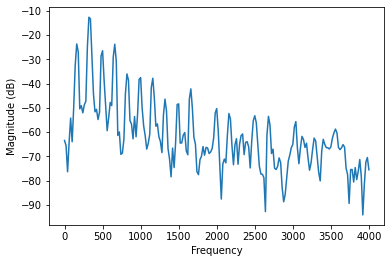

In [2]:
def SNR_to_noise_power(signal_power, SNR_dB):
    """
    Solve the SNR formula

        SNR_dB = 10 log10[signal_power/noise_power]

    for noise_power.
    """
    noise_power = signal_power*10.**(-SNR_dB/10.)
    return noise_power

rate, data = wav.read('../data/3-notes.wav')
data = data/amax(abs(data))
data -= mean(data)

x = data[:, 0]
t = arange(len(x))*1000./rate

first_note = x[6100:6500]
second_note = x[7800:8200]
third_note = x[10000:10400]

full_t = linspace(0, 400*1000./rate, 400)  # msec
full_x = first_note

train_t = concatenate((full_t[:200], full_t[300:]))
train_x = concatenate((full_x[:200], full_x[300:]))
test_t = full_t[200:300]
test_x = full_x[200:300]

var_x = var(train_x)
std_x = sqrt(var_x)

spectrum, freqs, _ = magnitude_spectrum(full_x, Fs=rate, scale='dB')
fmax = freqs[argmax(spectrum)]  # Hz
f0 = fmax/2  # Hz
Tmax = 1000./fmax  # msec
T0 = Tmax*2  # msec

SNR = 20  # dB
noise_var = SNR_to_noise_power(var_x, SNR)

ell_guess = Tmax/(2*pi)
ell_period_guess = T0/(4*pi)
ell_guess_modulator = 50*T0/(2*pi)

## Implementation

### GPy 

In [3]:
full_T = full_t[:, None]
full_X = full_x[:, None]
train_T = train_t[:, None]
train_X = train_x[:, None]
test_T = test_t[:, None]
test_X = test_x[:, None]

k1 = GPy.kern.GridRBF(1, variance=var_x, lengthscale=ell_guess_modulator)
k2 = GPy.kern.StdPeriodic(1, variance=1., period=T0,
                          lengthscale=ell_period_guess)

k2.variance.fix()

k = k1*k2

m = GPy.models.GPRegression(train_T, train_X, k, noise_var=noise_var)
m.optimize(messages=True)

xmean, _ = m.predict(test_T, full_cov=False)
MSE = mean((xmean[:,0] - test_x)**2)
GPy_SNR = 10. * log10(var(test_x) / MSE)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0003  -4.417543e+02   9.622193e+05 
    00s18  0004  -4.537860e+02   5.961962e+04 
    02s21  0047  -6.681300e+02   2.796581e-01 
    02s43  0053  -6.681315e+02   1.660168e-05 
Runtime:     02s43
Optimization status: Converged



### GPyTorch - default

In [4]:
full_T_tensor = torch.as_tensor(full_t)
full_X_tensor = torch.as_tensor(full_x)
train_T_tensor = torch.as_tensor(train_t)
train_X_tensor = torch.as_tensor(train_x)
test_T_tensor = torch.as_tensor(test_t)
test_X_tensor = torch.as_tensor(test_x)

k = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() * gpytorch.kernels.PeriodicKernel())
k.outputscale = var_x
k.base_kernel.kernels[0].lengthscale = ell_guess_modulator
k.base_kernel.kernels[1].lengthscale = ell_period_guess
k.base_kernel.kernels[1].period_length = T0

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = k

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = noise_var
model = ExactGPModel(train_T_tensor, train_X_tensor, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 1000
    
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_T_tensor)
    loss = -mll(output, train_X_tensor)
    loss.backward()
    optimizer.step()

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    xmean = likelihood(model(test_T_tensor)).mean
    
MSE = mean((xmean.detach().numpy() - test_x)**2)
GPyTorch_SNR = 10. * log10(var(test_x) / MSE)

### GPyTorch - GPU

In [6]:
full_T_gpu = full_T_tensor.cuda()
full_X_gpu = full_X_tensor.cuda() 
train_T_gpu = train_T_tensor.cuda()
train_X_gpu = train_X_tensor.cuda()
test_T_gpu = test_T_tensor.cuda()
test_X_gpu = test_X_tensor.cuda()

k = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() * gpytorch.kernels.PeriodicKernel())
k.outputscale = var_x
k.base_kernel.kernels[0].lengthscale = ell_guess_modulator
k.base_kernel.kernels[1].lengthscale = ell_period_guess
k.base_kernel.kernels[1].period_length = T0

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = k

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
likelihood.noise_covar.noise = noise_var
model = ExactGPModel(train_T_gpu, train_X_gpu, likelihood).cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 1000
    
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_T_gpu)
    loss = -mll(output, train_X_gpu)
    loss.backward()
    optimizer.step()

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    xmean = likelihood(model(test_T_gpu)).mean
    
MSE = mean((xmean.detach().cpu().numpy() - test_x)**2)
GPyTorchGPU_SNR = 10. * log10(var(test_x) / MSE)

## Test results

Comparing the signal to noise ratio achieved by each model. 

In [7]:
print("--- Signal to Noise Ratio ---")
print(f"GPy: ", GPy_SNR)
print(f"GPyTorch - default: ", GPyTorch_SNR)
print(f"GPyTorch - GPU: ", GPyTorchGPU_SNR)

--- Signal to Noise Ratio ---
GPy:  24.57843979494759
GPyTorch - default:  24.57846282663073
GPyTorch - GPU:  24.5784622736167
